# Model

In [185]:
import gym
from scipy.special import hyp2f1
from numpy.random import rand
from numpy.linalg import norm
from numpy import array
from numpy import zeros, zeros_like
from numpy import ones, ones_like
from numpy import inf
from numpy import minimum, maximum

In [7]:
def g(h,hb,z,zb):
    return (1/2 if h==hb else 1)*(z**h*zb**hb*hyp2f1(h,h,2*h,z)*hyp2f1(hb,hb,2*hb,zb)+zb**h*z**hb*hyp2f1(h,h,2*h,zb)*hyp2f1(hb,hb,2*hb,z))

In [8]:
def p(h,hb,c,z,zb):
    return c*(((z-1)*(zb-1))**(1/8)*g(h,hb,z,zb)-z**(1/8)*zb**(1/8)*g(h,hb,1-z,1-zb))

In [9]:
pts = rand(29,2)

In [10]:
def e(spec,pts):
    return [(sum([p(n[0],n[1],n[2],z[0],z[1]) for n in spec]) + ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts]

In [11]:
test_spec = array([[2.,2.,2.44e-4],[.5,.5,.25],[2.,0.,.016],[4.,0.,2.2e-4],[6.,0.,1.36e-5]])

In [12]:
spins = array([0,0,2,4,6])

In [467]:
class IsingEnv(gym.Env):
    def __init__(self):
        self.action_space = gym.spaces.Box(array([-1 for i in range(10)]), array([1 for i in range(10)]))
        self.observation_space = gym.spaces.Box(array([-inf for i in range(29)]),array([inf for i in range(29)]))
        self.n = 5
    def step(self, action, old_reward):
        self.state += action
        self.state = maximum(zeros_like(self.state), self.state)
        self.state = minimum(6.5*ones_like(self.state), self.state)
        obs = self._get_obs()
        reward = -norm(obs)
        if reward > old_reward:
            done = True
        else:
            done = False
        info = {}
        return obs, reward, done, info
    def reset(self):
        self.state = rand(10)
        return self._get_obs()
    def _get_obs(self):
        spec = [[(self.state[2*i]+spins[i])/2, (self.state[2*i]-spins[i])/2, self.state[2*i+1]]for i in range(self.n)]
        return e(spec, pts)

In [429]:
class IsingEnv2(gym.Env):
    def __init__(self):
        self.action_space = gym.spaces.Dict({"index":gym.spaces.Discrete(10), "magnitude":gym.spaces.Box(low=array([-1]),high=array([1]))})
        self.observation_space = gym.spaces.Box(array([-inf for i in range(29)]),array([inf for i in range(29)]))
        self.n = 5
    def step(self, action, old_reward):
        self.state[action["index"]] += action["magnitude"]
        self.state[action["index"]] = maximum(0, self.state[action["index"]])
        self.state[action["index"]] = minimum(6.5, self.state[action["index"]])
        obs = self._get_obs()
        reward = -norm(obs)
        if reward > old_reward:
            done = True
        else:
            done = False
        info = {}
        return obs, reward, done, info
    def reset(self):
        self.state = rand(10)
        return self._get_obs()
    def _get_obs(self):
        spec = [[(self.state[2*i]+spins[i])/2, (self.state[2*i]-spins[i])/2, self.state[2*i+1]]for i in range(self.n)]
        return e(spec, pts)

In [430]:
ising = IsingEnv()

/home/tzuchen/PycharmProjects/ReinforcementBootstrap/venv/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


# Network

In [468]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [469]:

class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [470]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [471]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

In [472]:
def update(batch_size,gamma=0.99,soft_tau=1e-3,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [473]:
env = IsingEnv()

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 5e-4
soft_q_lr = 5e-4
policy_lr = 5e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

replay_buffer_size = 100000
replay_buffer = ReplayBuffer(replay_buffer_size)

/home/tzuchen/PycharmProjects/ReinforcementBootstrap/venv/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [474]:
max_frames  = 4000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 64

In [ ]:
max_reward = -inf
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_net.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy(), max_reward)
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action, max_reward)
        
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
        if done:
            max_reward = reward
            break
    rewards.append(episode_reward)

/home/tzuchen/PycharmProjects/ReinforcementBootstrap/venv/lib64/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64, 10])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [419]:
max_reward

-13.09155483550659

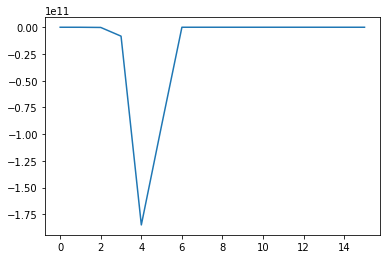

In [420]:
plt.plot(rewards)

In [421]:
env.state

array([0. , 6.5, 0. , 6.5, 6.5, 6.5, 0. , 0. , 6.5, 0. ])

In [422]:
-norm(env._get_obs())

-976.6383027000994